In [2]:
from __future__ import print_function
from __future__ import division

import make_dictionaries
import os
import math

questions = make_dictionaries.questions
function_dictionary = make_dictionaries.function_dictionary

In [3]:
%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
# better-looking plots
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.figsize'] = (10.0, 8)
plt.rcParams['font.size'] = 18
mpl.ticker.AutoLocator.default_params['nbins'] = 5
mpl.ticker.AutoLocator.default_params['prune'] = 'both'

In [4]:
import numpy as np
from astropy.io import fits
from astropy.table import Table
from scipy.stats import binned_statistic, scoreatpercentile
import pickle
from scipy.optimize import minimize
import time

In [5]:
import params

source_directory = params.source_directory
save_directory = params.numpy_save_directory
full_sample = params.full_sample
volume_limited_sample = params.volume_limited_sample
question = params.question
question_dictionary = params.question_dictionary
bins_to_plot = params.bins_to_plot
print('Question to be debiased: {}'.format(question))

min_log_fv = -1.5#np.log10(0.1)
max_log_fv = 0.1 #np.log10(0.9)

#min_log_fv = np.log10(0.1)
#max_log_fv = np.log10(0.8)

Question to be debiased: t01_smooth_or_features


In [6]:
all_data = fits.getdata(source_directory + full_sample,1)
vl_data = fits.getdata(source_directory + volume_limited_sample,1)
all_data = Table(all_data)
vl_data = Table(vl_data)
print('Loaded galaxy data...')
questions = make_dictionaries.questions
print('Loaded question dictionary...')
function_dictionary = make_dictionaries.function_dictionary
print('Loaded function dictionary...')
# Stuff obtained from the voronoi code:
all_voronoi = fits.getdata(save_directory+'bins.fits',1)
all_voronoi = Table(all_voronoi)
vbins_table = fits.getdata(save_directory+'vbins_table.fits',1)
vbins_table = Table(vbins_table)
print('Loaded voronoi bins...')

Loaded galaxy data...
Loaded question dictionary...
Loaded function dictionary...


OSError: File does not exist: 'npy/bins.fits'

In [6]:
vbins_table['density'] = vbins_table['count_gals']/vbins_table['count_rect_bins']
sorted_indices = vbins_table.argsort('density')
densest_vbin = vbins_table[sorted_indices[-1]]['vbin']
average_vbin = vbins_table[sorted_indices[len(sorted_indices)//2]]['vbin']
densest_vbin, average_vbin

(4, 17)

In [7]:
# Make a table for writing in data if none already exist:
if os.path.isfile(save_directory+'full_sample_debiased.fits') is True:
    all_data_save = fits.getdata(save_directory+'full_sample_debiased.fits',1)
    all_data_save = Table(all_data_save)
else:
    all_data_save = Table()
    
if os.path.isfile(save_directory+'vl_sample_debiased.fits') is True:
    vl_data_save = fits.getdata(save_directory+'vl_sample_debiased.fits',1)
    vl_data_save = Table(vl_data_save)
else:
    vl_data_save = Table()

In [8]:
def make_figure_directory(name):
    full_name = 'figures/' + question + '/' + name + '/'
    if os.path.isdir(full_name) is False:
        os.mkdir(full_name)
        print('Made directory:' + full_name)
    return None

os.makedirs('figures/' + question + '/') if os.path.isdir('figures/' + question + '/') is False else None
for name in ['fitted_results','fit_setups','kc_fitted_functions','debiased_plots']:
    make_figure_directory(name)

In [9]:
## from 01_select.py

def select_data_arm_number(data,debiased,question,questions,N_cut=5,p_cut=0.5):
    
    pre_questions = questions[question]['pre_questions']
    pre_answers = questions[question]['pre_answers']
    
    strings = [pre_questions[s] + '_' + pre_answers[s] for s in range(len(pre_answers))]
    p_strings = [s + '_debiased' for s in strings]
    N_string = strings[-1] + '_count'

    p_values = np.ones(len(data))
    N_values = np.ones(len(data))

    for Q in p_strings:
        p_values = p_values*debiased[Q]
    N_values = N_values*data[N_string]

    select = (p_values > p_cut) & (N_values >= N_cut)
    
    print('{}/{} ({}%) galaxies selected in sample with p>{} and N>={}.'.format(np.sum(select),len(select),
                                                                               100*np.sum(select)/len(select),p_cut,N_cut))
    
    return select

In [10]:
## from 11_voronoi_assignment.py

def redshift_binning(data,voronoi_bins,question,questions,min_gals=50):
    
    answers = questions[question]['answers']
    morph_fv_cols = ['{}_{}_weighted_fraction'.format(question, a) 
                     for a in answers]
    redshift = data['REDSHIFT_1']
    z_bins = np.zeros((len(morph_fv_cols), len(data)), np.int)

    for N in np.unique(voronoi_bins):
        inbin = voronoi_bins == N

        for m, fv_col in enumerate(morph_fv_cols):
            # Select bins such that >= min_gals objects
            # with at least one vote are in each bin
            has_morph = data[fv_col][inbin] > 0
            n_with_morph = (has_morph).sum()
            n_zbins = n_with_morph / min_gals 
            n_zbins = max(n_zbins, 5)
            z = redshift[inbin]
            z_with_morph = z[has_morph]
            z_with_morph.sort()
            bin_edges = np.linspace(0, len(z_with_morph)-1, n_zbins+1, dtype=np.int)
            z_edges = z_with_morph[bin_edges]
            z_edges[0] = 0
            z_edges[-1] = 1
            z_bins[m, inbin] = np.digitize(z, z_edges)

    return z_bins

In [11]:
def save_bin_assignments(v_bins, z_bins, question='t11_arms_number'):
    assignments = Table(data=[v_bins], names=['vbin'])
    for m in range(len(z_bins)):
        zcol = 'zbin_{}'.format(m)
        assignments[zcol] = z_bins[m]
    assignments.write(save_directory + 'bin_assignments_{}.fits'.format(question),
                      overwrite=True)
    return assignments

In [12]:
if questions[question]['pre_questions'] != None:
    select = select_data_arm_number(all_data,all_data_save,question,questions)
    data = all_data[select]
    voronoi = all_voronoi[select]

else:
    data = all_data
    voronoi = all_voronoi
    print('Primary question, so all {} galaxies used for debiasing.'.format(len(data)))

Primary question, so all 248883 galaxies used for debiasing.


In [13]:
redshift_bins = redshift_binning(data, voronoi['voronoi_bin'],question,questions)
bin_assignments = save_bin_assignments(voronoi['voronoi_bin'],redshift_bins,question)
print('Redshift bins assigned')

Redshift bins assigned


In [14]:
#def f_logistic(x, k, c):
    # Function to fit the data bin output from the raw plot function
    #L = 1 + np.exp(c)
    #r = L / (1.0 + np.exp(-k * x + c))
    #return r


#def f_inv_x(x,k,c):
    # Function to fit the data bin output from the raw plot function
    #r = 1/(1 + k*((-x))**c)
    #return r


#def f_exp_pow(x, k, c):
    # Function to fit the data bin output from the raw plot function
    #r = np.exp(-k * (-x) ** c)
    #return r


def chisq_fun(p, f, x, y):
    return ((f(x, *p) - y)**2).sum()

In [15]:
#def i_f_logistic(y, k, c):
    # inverse of f_logistic
    #L = 1 + np.exp(c)
    #x = -(np.log(L / y - 1) - c) / k
    #return x

#def i_f_exp_pow(y, k, c):
    # inverse of f_exp_pow
    #ok = k > 0
    #x = np.zeros_like(y) - np.inf
    #x[ok] = -(-np.log(y[ok]) /k[ok] )**(1.0/c[ok])
    #return x

#def i_f_inv_x(y,k,c):
    # inverse of f_inv_x
    #x = -((((1/y)-1)/k))**(1/c)
    #return x

#def inverse_f(f):
    #if f == f_logistic:
        #return i_f_logistic
    #elif f == f_inv_x:
        #return i_f_inv_x
    #elif f == f_exp_pow:
        #return i_f_exp_pow

In [16]:
def plot_raw(ax, D, color):
    # Plot cumulative fractions for the raw data
    ax.plot(D['log10fv'], D['cumfrac'], '-', color=color, lw=2, alpha=0.2)


def plot_function(ax, f, x, p, color, style='--'):
    # Plot fitted function to cumulative fractions
    ax.plot(x, f(x, *p), style, color=color, lw=0.5)


def plot_guides(ax):
    # Plot guides at 20%, 50%, 80%
    x_guides = np.log10([0.2, 0.5, 0.8])
    y_guides = np.array([0, 1.05])
    for xg in x_guides:
        ax.plot([xg, xg], y_guides, color=[0, 0, 0], alpha=0.3)

        
def plot_limits(x, p=1, d=0.05):
    low, high = scoreatpercentile(x, (p, 100-p))
    diff = high-low
    low -= d * diff
    high += d * diff
    return low, high


def finish_vbin_plot(fig, ax, answerlabels, m, v):
    plot_guides(ax)
    ax.tick_params(axis='both', labelsize=10)
    ax.set_xticks(np.arange(-1.5, 0.1, 0.5))
    ax.text(-1.9, 0.95, answerlabels[m],
            fontsize=10, ha='left')
    ax.set_ylim([0, 1.05])
    if m > 2:
        ax.set_xlabel(r'$\log(v_f)$')
    if m in (0, 3):
        ax.set_ylabel('Cumulative fraction')
    if m == 1:
        ax.set_title('Voronoi bin %02i' % v)
    fig.subplots_adjust(wspace=0, hspace=0)

In [17]:
def fit_vbin_function(data, bin_assignments, fit_setup,
                      question,questions,kc_fit_results=None,
                      plot=bins_to_plot,min_log_fv=min_log_fv,
                      even_sampling=True):
    # Output fitted function for each of the Voronoi bins,
    # arm numbers and redshift bins.
    
    start_time = time.time()
    
    answers = questions[question]['answers']
    answerlabels = questions[question]['answerlabels']

    morph_fv_cols = ['{}_{}_weighted_fraction'.format(question, a) 
                     for a in answers]
    redshift = data['REDSHIFT_1']
    vbins = bin_assignments['vbin']

    if kc_fit_results is not None:
        kcfunc, kparams, cparams, kclabel = kc_fit_results
    
    # Set up the list to write the parameters in to:
    param_data = []
    
    max_z_bins_to_plot = 5
    
    # Loop over Voronoi magnitude-size bins
    for v in np.unique(vbins):
        vselect = vbins == v
        data_v = data[vselect]
        bin_assignments_v = bin_assignments[vselect]

        if v in plot:
            fig,axarr = make_axes(n_morph=len(answers))
            x = np.linspace(-2,0,1000)

        # Loop over morphological categories
        for m, fv in enumerate(morph_fv_cols):
            z_bins = bin_assignments_v['zbin_{}'.format(m)]
            z_bins_unique = np.unique(z_bins)
            n_z_bins = len(z_bins_unique)
            z_bins_to_plot = z_bins_unique[::(n_z_bins // max_z_bins_to_plot) + 1]
            z_min = z_bins.min()
            z_max = z_bins.max()
            clr_diff = (1.0 / (z_max - z_min)) if z_max - z_min != 0 else 0

            # Loop over redshift slices
            for z in z_bins_unique:
                data_z = data_v[z_bins == z]
                n = len(data_z)
                clr_z = [min((z - 1) * clr_diff, 1), 0,
                         max(1 - (z - 1) * clr_diff, 0)]

                # Compute cumulative fraction
                D = data_z[[fv]]
                D.sort(fv)
                D['cumfrac'] = np.linspace(0, 1, n)
                #D = D[D[fv] > min_fv]
                D['log10fv'] = np.log10(D[fv])
                if even_sampling:
                    D_log10fv = np.log10(np.linspace(10**min_log_fv, 1, 100))
                    indices = np.searchsorted(D['log10fv'], D_log10fv)
                    D = D[indices.clip(0, len(D)-1)]
                else:
                    D = D[D['log10fv'] > min_log_fv]

                # Fit function to the cumulative fraction
                # Start fits off in roughly right place with sensible bounds
                func, p0, bounds = get_fit_setup(fit_setup, m)
                # Note that need to cast x and y to float64 in order
                # for minimisation to work correctly
                res = minimize(chisq_fun, p0,
                               args=(func,
                                     D['log10fv'].astype(np.float64),
                                     D['cumfrac'].astype(np.float64)),
                               bounds=bounds, method='SLSQP')
                p = res.x
                chi2nu = res.fun / (n - len(p))
                
                means = [data_z['PETROMAG_MR'].mean(),
                         np.log10(data_z['PETROR50_R_KPC']).mean(),
                         data_z['REDSHIFT_1'].mean()]
                                
                if v in plot and z in z_bins_to_plot:
                    ax = axarr[m]
                    plot_raw(ax, D, clr_z)
                    plot_function(ax, func, x, p, clr_z)
                    if kc_fit_results is not None:
                        kf = kcfunc(means, *kparams[m])
                        cf = kcfunc(means, *cparams[m])
                        plot_function(ax, func, x, (kf, cf), clr_z, style=':')

                if len(p) < 2:
                    p = np.array([p[0], 10])

                param_data.append([v, m, z] + means + p[:2].tolist() +
                                  [chi2nu])

            if v in plot:
                finish_vbin_plot(fig, ax, answerlabels, m, v)
        if v in plot:
            
            suffix = '_kcfit{}'.format(kclabel) if kc_fit_results is not None else ''
            fig.savefig('figures/' + question + '/fitted_results/fit_{}_vbin{:02d}{}.pdf'.format(question, v, suffix),
                        dpi=100)
            plt.close()

    fit_vbin_results = Table(rows=param_data,
                             names=('vbin', 'answer', 'zbin', 'Mr',
                                    'R50', 'redshift', 'k', 'c', 'chi2nu'))
    fit_vbin_results.write(save_directory + 'fit_vbin_results_{}.fits'.format(question),
                           overwrite=True)
    
    print('All bins fitted! {}s in total'.format(time.time()-start_time))
    
    return fit_vbin_results

In [18]:
def get_fit_setup(fit_setup, m):
    def get_m(x):
        return x[m] if m in x.keys() else x[None]
    func = get_m(fit_setup['func'])
    p0 = get_m(fit_setup['p0'])
    bounds = get_m(fit_setup['bounds'])
    return func, p0, bounds

In [19]:
def make_axes(n_morph,xlabel='$\log(f_v)$',ylabel='cumulative fraction'):

    x_dimension = math.ceil(math.sqrt(n_morph))
    y_dimension = math.ceil(n_morph/x_dimension)
    n_plots = x_dimension*y_dimension
    n_spare = n_plots-n_morph
    remove_axes = np.arange(-n_spare,0)
    fig,axes = plt.subplots(y_dimension,x_dimension,sharex=True,sharey=True,figsize=(5*x_dimension,5*y_dimension))
    if n_morph >= 3:
        for ax in axes[-1,:]:
            ax.set_xlabel(xlabel)
        for ax in axes[:,0]:
            ax.set_ylabel(ylabel) 
    else:
        axes[0].set_xlabel(xlabel)
        axes[0].set_ylabel(ylabel)
        axes[1].set_xlabel(xlabel)
    plt.subplots_adjust(hspace=0,wspace=0)
    axes=axes.ravel()
    for m in remove_axes:
        fig.delaxes(axes[m])
    return fig,axes

In [20]:
# Choose the best fit setup for arm number:

def make_setup_dictionary(data, question, questions, function_dictionary=function_dictionary,
                          bin_assignments=bin_assignments, vbin=None,
                          plot=True,min_log_fv=min_log_fv,max_log_fv=max_log_fv,
                          even_sampling=True):

    fit_setup = {}
    fit_setup['func'] = {None: None}
    fit_setup['bounds'] = {None: None}
    fit_setup['p0'] = {None:None}
    fit_setup['inverse'] = {None:None}

    n_morph = len(questions[question]['answers'])
    fig,axes = make_axes(n_morph)

    if vbin is not None:
        vbins = bin_assignments['vbin']
        vselect = vbins == vbin
        data = data[vselect]
    
    fractions = [question + '_' + s + '_weighted_fraction' for s in questions[question]['answers']]
    counts = [question + '_' + s + '_count' for s in questions[question]['answers']]

    for m in range(n_morph):
    
        p_values = np.log10(np.sort(data[fractions[m]]))
        n = len(p_values)
        cumfrac = np.linspace(0,1,n)
        D = Table(np.array([cumfrac,p_values]).T,names=('cumfrac','log10fv'))
        # usually see a 'levelling off' at the low end, so don't fit below min_log_fv.
        if even_sampling:
            D_fit_log10fv = np.log10(np.linspace(10**min_log_fv, 1, 1000))
            indices = np.searchsorted(D['log10fv'], D_fit_log10fv)
            D_fit = D[indices.clip(0, len(D)-1)]
        else:
            D_fit = D[(D['log10fv'] > min_log_fv) & (D['log10fv'] < max_log_fv)] 

        axes[m].plot(D['log10fv'],D['cumfrac'],'k-',linewidth=2)
        
        chisqs = []
        best_kcs = []
        
        for f in range(len(function_dictionary['func'])):
        
            p0 = function_dictionary['p0'][f]
            func = function_dictionary['func'][f]
            bounds = function_dictionary['bounds'][f]
            
            res = minimize(chisq_fun,x0=p0,
                               args=(func,
                                     D_fit['log10fv'].astype(np.float64),
                                     D_fit['cumfrac'].astype(np.float64)),
                                     method='SLSQP',bounds=bounds)
        
            chisqs.append(res.fun)
            best_kcs.append(res.x)
            print(m, func, res.x, res.fun)
        
        best_f = np.argmin(chisqs)
        chisq = np.min(chisqs)
        best_func = function_dictionary['func'][best_f]
        best_kc = best_kcs[best_f]
        best_bounds = function_dictionary['bounds'][best_f]
        best_label = function_dictionary['label'][best_f]
        best_inverse = function_dictionary['i_func'][best_f]
        
        print('{a} function selected for {b} (chisq={c:.3g})'.format(a=best_label,c=chisq,
                                                                 b=questions[question]['answers'][m]))
                    
        xg = np.linspace(-2,0,100)
        #axes[m].plot(xg,f_inv_x(xg,res_inv.x[0],res_inv.x[1]),'g--',linewidth=2)
    
        fit_setup['func'].update({m:best_func})
        fit_setup['bounds'].update({m:best_bounds})
        fit_setup['p0'].update({m:best_kc})
        fit_setup['inverse'].update({m:best_inverse})
    
        axes[m].text(0.98,0.1,
                     ('$\chi^{2}' + '_{{{}}}'.format(best_label) + '={0:.3g}$'.format(chisq))
                     ,family='serif',horizontalalignment='right',verticalalignment='top'
                     ,transform = axes[m].transAxes,size=15,color='red')
        
        axes[m].text(0.04,0.95,questions[question]['answerlabels'][m]
                     ,family='serif',horizontalalignment='left',verticalalignment='top'
                     ,transform = axes[m].transAxes,size=15)
        
        axes[m].plot(xg,best_func(xg,best_kc[0],best_kc[1]),'r--',linewidth=2)
    
    plt.xlim(-2,0)
    plt.ylim(0,1)
    
    if plot == True:
        plt.savefig('figures/' + question + '/fit_setups/' + question + '_setup.pdf')
        
    return fit_setup

23.8482023913
0.275039860432
0.293669130907


/usr/local/anaconda/envs/py3k/lib/python3.4/site-packages/ipykernel/__main__.py:8: RuntimeWarning: divide by zero encountered in log10


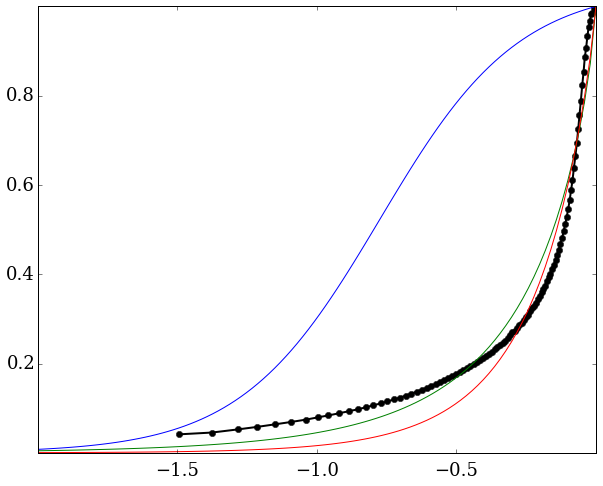

In [190]:
n_morph = len(questions[question]['answers'])

fractions = [question + '_' + s + '_weighted_fraction' for s in questions[question]['answers']]
counts = [question + '_' + s + '_count' for s in questions[question]['answers']]

m=0

p_values = np.log10(np.sort(data[fractions[m]]))
n = len(p_values)
cumfrac = np.linspace(0,1,n)
D = Table(np.array([cumfrac,p_values]).T,names=('cumfrac','log10fv'))
D_fit = D[(D['log10fv'] > min_log_fv) & (D['log10fv'] < max_log_fv)] # usually see a 'levelling off' ath the
# low end, so don't fit this.


# Sample the cumulative histogram atequally spaced points in log_fv
#D_fit_log10fv = np.linspace(min_log_fv, 0, 10)
# Sample the cumulative histogram atequally spaced points in fv
D_fit_log10fv = np.log10(np.linspace((10**min_log_fv), 1, 100))
# Sample the cumulative histogram atequally spaced points in sqrt(fv)
#D_fit_log10fv = np.log10(np.linspace((10**min_log_fv)**(1/2.), 1, 10)**(2.))
indices = np.searchsorted(D['log10fv'], D_fit_log10fv)
D_fit = D[indices]

plt.plot(D_fit['log10fv'],D_fit['cumfrac'],'k-o',linewidth=2)

x = np.linspace(-2,0,100)

p = (4, -3.1)
y = make_dictionaries.f_logistic(x, *p)
plt.plot(x, y)
print(((make_dictionaries.f_logistic(D_fit['log10fv'], *p) - D_fit['cumfrac'])**2).sum())

p = (3.1, 0.8)
y = make_dictionaries.f_exp_pow(x, *p)
plt.plot(x, y)
print(((make_dictionaries.f_exp_pow(D_fit['log10fv'], *p) - D_fit['cumfrac'])**2).sum())

p = (4.13, 0.91)
y = make_dictionaries.f_exp_pow(x, *p)
plt.plot(x, y)
print(((make_dictionaries.f_exp_pow(D_fit['log10fv'], *p) - D_fit['cumfrac'])**2).sum())



0 <function f_logistic at 0x105340f28> [ 6.99827588  0.        ] 6.97257958384
0 <function f_inv at 0x10589a048> [ 20.           0.46221531] 102.8342794
0 <function f_exp_pow at 0x10589a0d0> [ 3.27933901  0.78603375] 2.29752323271
exp. power function selected for a01_smooth (chisq=2.3)
1 <function f_logistic at 0x105340f28> [ 1.80625758 -0.2262781 ] 1.1300918456
1 <function f_inv at 0x10589a048> [ 10.58628758   0.67565921] 22.8432048365
1 <function f_exp_pow at 0x10589a0d0> [ 1.13385792  1.13571511] 1.4644933404
logistic function selected for a02_features_or_disk (chisq=1.13)
2 <function f_logistic at 0x105340f28> [ 5.02712571 -7.84815371] 0.0189182154352
2 <function f_inv at 0x10589a048> [ 1.18811705  0.08102016] 10.6983918197
2 <function f_exp_pow at 0x10589a0d0> [ 0.1  3. ] 0.307599965244
logistic function selected for a03_star_or_artifact (chisq=0.0189)


/usr/local/anaconda/envs/py3k/lib/python3.4/site-packages/ipykernel/__main__.py:27: RuntimeWarning: divide by zero encountered in log10
/usr/local/anaconda/envs/py3k/lib/python3.4/site-packages/matplotlib/lines.py:659: RuntimeWarning: invalid value encountered in subtract
  return np.amin(x[1:] - x[0:-1]) >= 0


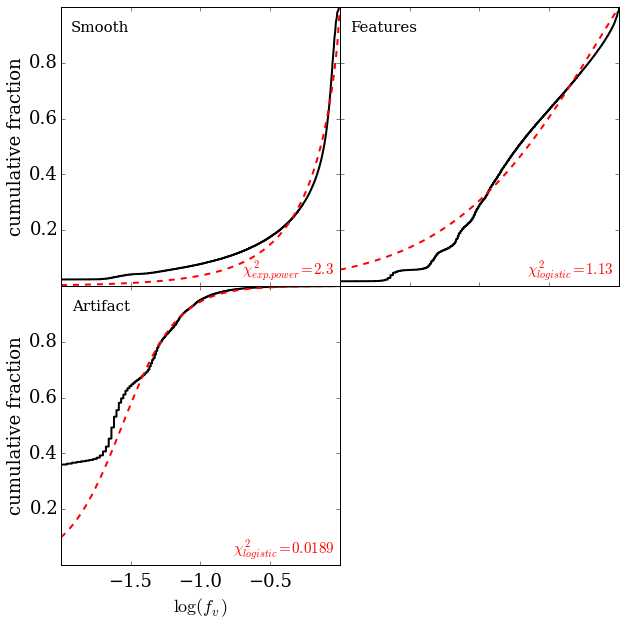

In [223]:
fit_setup = make_setup_dictionary(data,question,questions,function_dictionary,
                                  bin_assignments, vbin=None)

In [193]:
fit_setup

{'bounds': {0: ((0.1, 50), (0.01, 3)),
  1: ((0.1, 50), (-10.0, 0)),
  2: ((0.1, 50), (-10.0, 0)),
  None: None},
 'func': {0: <function make_dictionaries.f_exp_pow>,
  1: <function make_dictionaries.f_logistic>,
  2: <function make_dictionaries.f_logistic>,
  None: None},
 'inverse': {0: <function make_dictionaries.i_f_exp_pow>,
  1: <function make_dictionaries.i_f_logistic>,
  2: <function make_dictionaries.i_f_logistic>,
  None: None},
 'p0': {0: array([ 3.27933901,  0.78603375]),
  1: array([ 1.80625758, -0.2262781 ]),
  2: array([ 5.02712571, -7.84815371]),
  None: None}}

In [194]:
fit_vbin_results = fit_vbin_function(data, bin_assignments, fit_setup,
                                     question,questions)
# This part takes the longest (fitting curves to the data)

/usr/local/anaconda/envs/py3k/lib/python3.4/site-packages/ipykernel/__main__.py:58: RuntimeWarning: divide by zero encountered in log10


KeyboardInterrupt: 

In [195]:
def plot_fit_vbin(question,questions,parameter='k', predictor=None):
    
    answerlabels = questions[question]['answerlabels']
    
    n_morph = len(questions[question]['answers'])
    fig, axarr = plt.subplots(n_morph, 3, sharey='row', sharex='col', figsize=(15,3*n_morph))
    def plot(ax, x, answer, colourby):
        r = fit_vbin_results[fit_vbin_results['answer'] == answer]
        if predictor is None:
            param = r[parameter]
        else:
            f, p = predictor
            var = np.array([r[c] for c in ['Mr', 'R50', 'redshift']], np.float64)
            if p is not None:
                param = f(var, *p[answer])
            else:
                param = f(var)
        ax.scatter(r[x], param, c=r[colourby], marker='.', edgecolor='')
        y, bin_edges, binnumber = binned_statistic(r[x], r[parameter], statistic='median')
        xc = 0.5 * (bin_edges[:-1] + bin_edges[1:])
        ax.plot(xc, y, 'k-')
        if predictor is not None:
            y, bin_edges, binnumber = binned_statistic(r[x], param, statistic='median')
            xc = 0.5 * (bin_edges[:-1] + bin_edges[1:])
            ax.plot(xc, y, 'k--')
        low, high = plot_limits(r[parameter])
        ax.axis(ymin=low, ymax=high)
    for a, axrow in enumerate(axarr):
        plot(axrow[0], 'redshift', a, 'vbin')
        plot(axrow[1], 'R50', a, 'redshift')
        plot(axrow[2], 'Mr', a, 'redshift')
        axrow[0].set_ylabel("${}$ ({})".format(parameter,answerlabels[a]))
        if a == len(axarr) - 1:
            axrow[0].set_xlabel('$z$')
            axrow[1].set_xlabel('$\log_{10}{R_{50}}$')
            axrow[2].set_xlabel('$M_r$')
    fig.subplots_adjust(hspace=0, wspace=0)

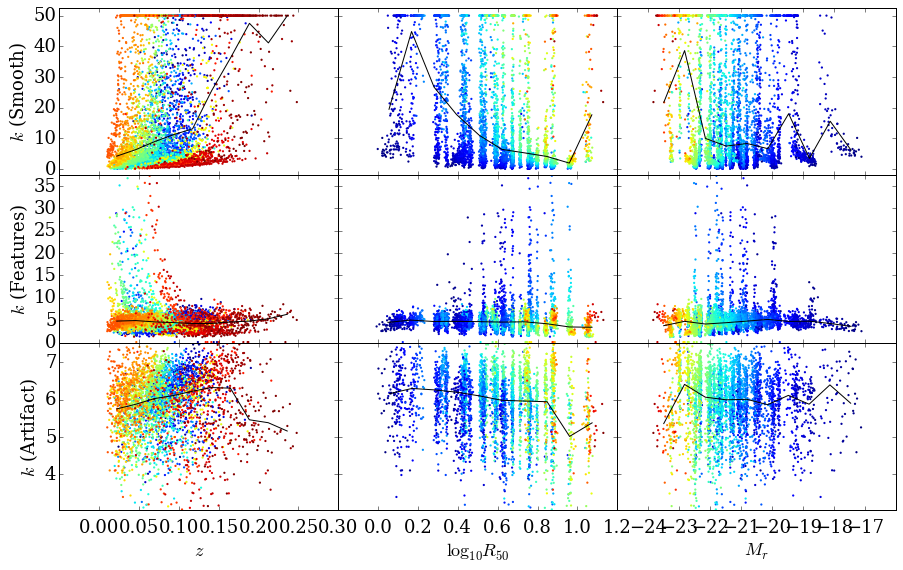

In [196]:
plot_fit_vbin(question,questions,'k')
plt.savefig('figures/' + question + '/kc_fitted_functions/{}_k_x.pdf'.format(question))

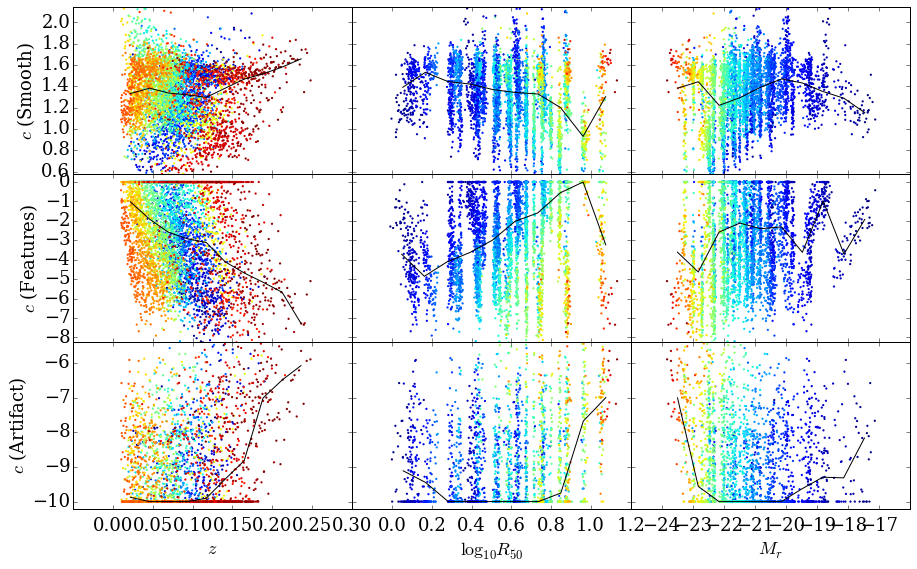

In [197]:
plot_fit_vbin(question,questions,'c')
plt.savefig('figures/' + question +'/kc_fitted_functions/{}_c_x.pdf'.format(question))

In [207]:
def normalise(x):
    return (x - x.mean())/x.std()

fit_vbin_results['Mr_norm'] = normalise(fit_vbin_results['Mr'])
fit_vbin_results['R50_norm'] = normalise(fit_vbin_results['R50'])
fit_vbin_results['redshift_norm'] = normalise(fit_vbin_results['redshift'])

In [220]:
from scipy.optimize import curve_fit


def kcfunc(x, A0, AM, AR, Az):
    # linear combination of (magnitude, size, redshift) + an offset
    r = A0 + AM*x[0] + AR*x[1] + Az*x[2] 
    return r


def fit_mrz(d, f=kcfunc):
    # Fit a linear function of M, R and z to k and c

    answers = d['answer']
    answer_list = np.unique(answers)
    n_answers = len(answer_list)
    
    dout = d.copy()
    dout['kf'] = np.zeros(len(d))
    dout['cf'] = np.zeros(len(d))
    
    kparams = []
    cparams = []
    
    kmin = [d[answers == a]['k'].min() for a in answer_list]
    kmax = [d[answers == a]['k'].max() for a in answer_list] 
    cmin = [d[answers == a]['c'].min() for a in answer_list]
    cmax = [d[answers == a]['c'].max() for a in answer_list] 

    # Loop over GZ morphologies
    for a in answer_list:
        select = answers == a
        da = d[select]
        x = np.array([da[c] for c in ['Mr', 'R50', 'redshift']], np.float64)
        k = da['k'].astype(np.float64)
        c = da['c'].astype(np.float64)

        kp, kc = curve_fit(f, x, k, maxfev=1000)
        cp, cc = curve_fit(f, x, c, maxfev=1000)
        
        kres = f(x, *kp) - k
        knormres = normalise(kres)
        plt.hist(knormres, alpha=0.3)

        cres = f(x, *cp) - c
        cnormres = normalise(cres)
        plt.hist(cnormres, alpha=0.3)
        

        dout['kf'][select] = f(x, *kp)
        dout['cf'][select] = f(x, *cp)

        kparams.append(kp)
        cparams.append(cp)

    return kparams, cparams, dout, kmin, kmax, cmin, cmax

[array([-104.7241442 ,   -7.08205219,  -95.58578026,  350.42148216]), array([ -7.74792749,  -0.64677415,  10.08094131, -79.13777678]), array([ 2.31738562, -0.21151178, -2.6623968 ,  7.45208725])]
[array([ 3.20680428,  0.09012081, -0.30935671,  2.75925433]), array([  7.60490243,   0.62720427,  12.04597209, -50.0282595 ]), array([  1.85340889,   0.61720075,   1.01890001,  18.15510365])]


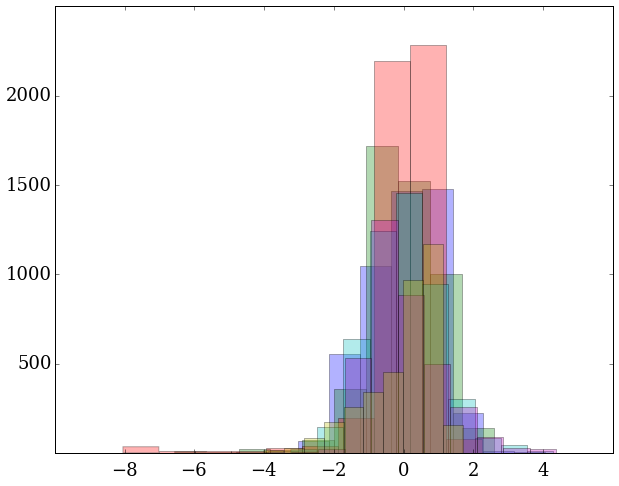

In [221]:
kparams, cparams, dout, kmin, kmax, cmin, cmax = fit_mrz(fit_vbin_results, kcfunc)
print(kparams)
print(cparams)

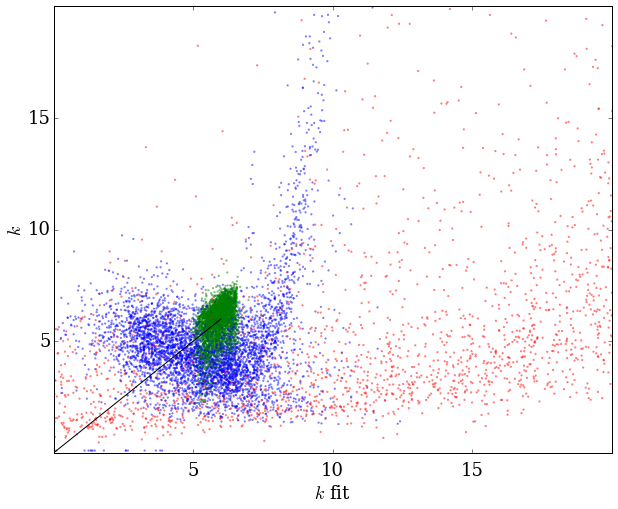

In [210]:
colours = 'rbgmc'
colours = [colours[i] for i in dout['answer']]

#answer1 (smooth) = red
#answer2 (features) = blue
#answer3 (artifact) = green

plt.scatter(dout['kf'], dout['k'], c=colours,
            marker='.', edgecolor='', alpha=0.5)
#plt.scatter(dout2['kf'], dout['k'], c='b',
            #marker='.', edgecolor='', alpha=0.5)
plt.plot([0, 6], [0, 6], 'k-')
plt.xlabel('$k$ fit')
plt.ylabel('$k$')
_ = plt.axis((0, 20, 0, 20))

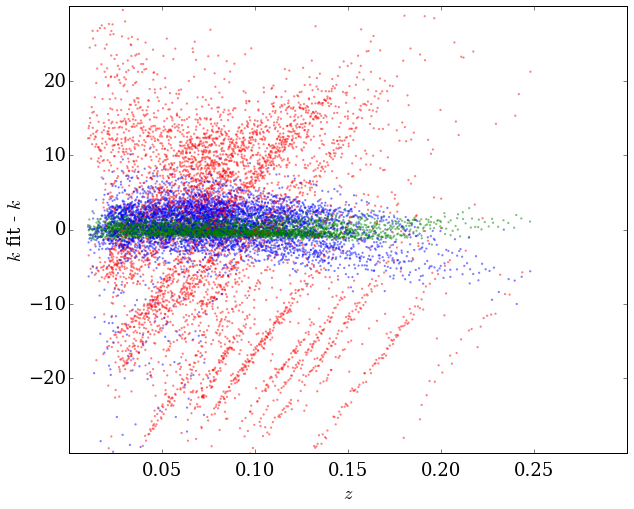

In [211]:
colours = 'rbgmc'
colours = [colours[i] for i in dout['answer']]

#answer1 (smooth) = red
#answer2 (features) = blue
#answer3 (artifact) = green

plt.scatter(dout['redshift'], dout['kf']-dout['k'], c=colours,
            marker='.', edgecolor='', alpha=0.5)
#plt.scatter(dout2['kf'], dout['k'], c='b',
            #marker='.', edgecolor='', alpha=0.5)
#plt.plot([0, 6], [0, 6], 'k-')
plt.xlabel('$z$')
plt.ylabel('$k$ fit - $k$')
_ = plt.axis((0, 0.3, -30, 30))

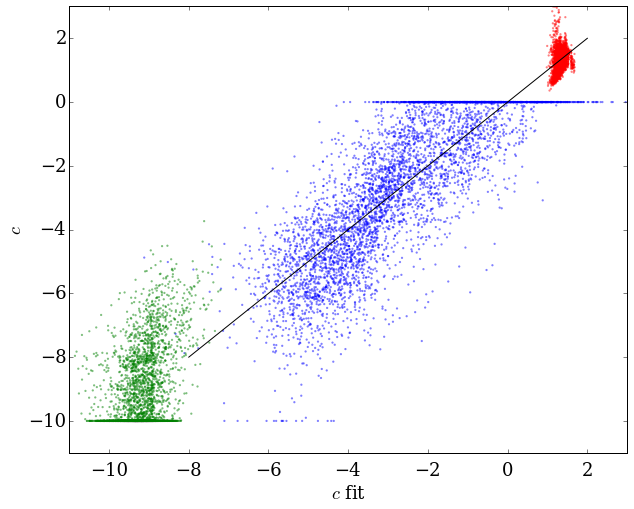

In [212]:
plt.scatter(dout['cf'], dout['c'], c=colours,
            marker='.', edgecolor='', alpha=0.5)
#plt.scatter(dout2['cf'], dout['c'], c='b',
            #marker='.', edgecolor='', alpha=0.5)
plt.plot([-8, 2], [-8, 2], 'k-')
plt.xlabel('$c$ fit')
plt.ylabel('$c$')
_ = plt.axis((-11, 3, -11, 3))

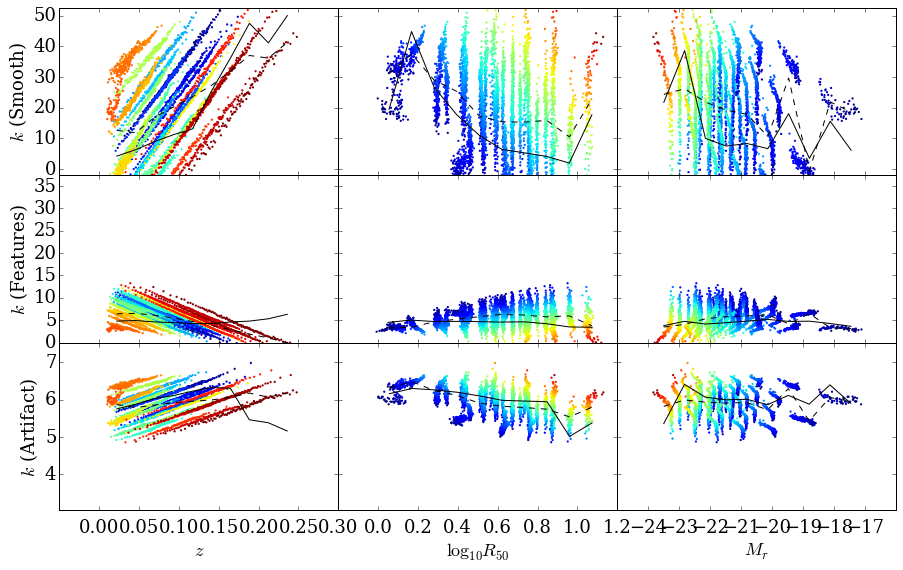

In [213]:
plot_fit_vbin(question,questions,'k', predictor=(kcfunc, kparams))
plt.savefig('figures/' + question + '/kc_fitted_functions/{}_k_x_fit1.pdf'.format(question))

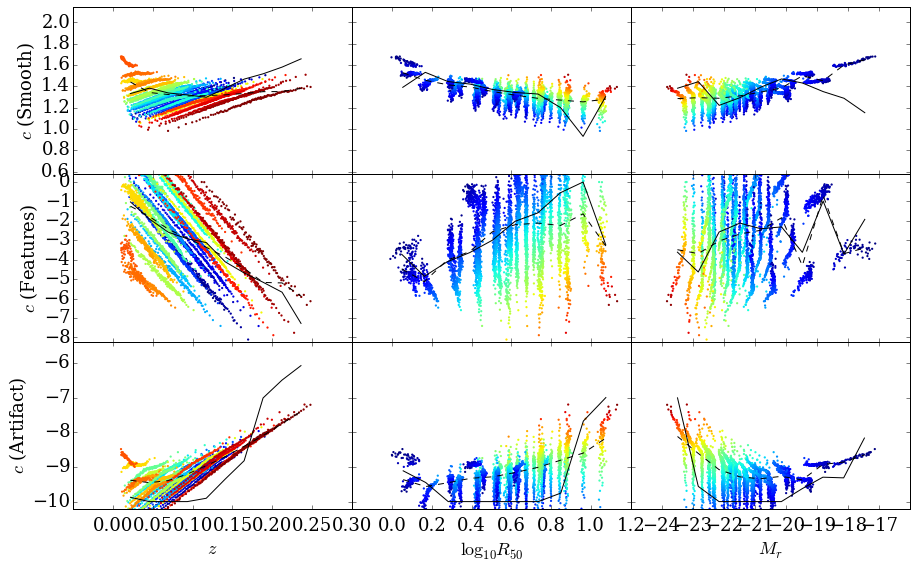

In [214]:
plot_fit_vbin(question,questions,'c', predictor=(kcfunc, cparams))
plt.savefig('figures/' + question + '/kc_fitted_functions/{}_c_x_fit1.pdf'.format(question))

In [206]:
# plot cumulative histograms with adopted fit
fit_vbin_results = fit_vbin_function(data, bin_assignments, fit_setup,
                                     question,questions,kc_fit_results=(kcfunc, kparams, cparams, 1))

/usr/local/anaconda/envs/py3k/lib/python3.4/site-packages/ipykernel/__main__.py:58: RuntimeWarning: divide by zero encountered in log10
/Users/spb/Work/projects/GalaxyZoo/Ross/Debiasing-testing-v2/Notebook/make_dictionaries.py:21: RuntimeWarning: divide by zero encountered in power
  r = np.exp(-k * (-x) ** c)


KeyboardInterrupt: 

In [35]:
import pickle
os.mkdir('save_stuff/') if os.path.isdir('save_stuff/') is False else None
with open('save_stuff/kparams.p', 'wb') as f:
    pickle.dump(kparams, f)
with open('save_stuff/cparams.p', 'wb') as f:
    pickle.dump(cparams, f)
with open('save_stuff/fit_setup.p', 'wb') as f:
    pickle.dump(fit_setup, f)

In [36]:
def function_inversion(value,func,k,kb,c,cb):
    # for use when function has no mathematical inverse
    xg = np.log10(np.linspace(0.01,1,100))
    low_z_values = func(xg,kb,cb)
    high_z_value = func(value,k,c)
    i = (np.abs(low_z_values-high_z_value)).argmin()
    x = xg[i]
    return x

In [42]:
def debias(data, z_base, kcfunc, kparams, cparams,
           question,questions):
    # Debias the dataset
    answers = questions[question]['answers']
    
    morph_fv_cols = ['{}_{}_weighted_fraction'.format(question, a) 
                     for a in answers]
    
    debiased = data[morph_fv_cols]

    # Each galaxy gets a function fit to its M,R and z parameters, which are scaled
    # to the equivalent M and r functions at low z.

    for m, fv_col in enumerate(morph_fv_cols):
        fv = debiased[fv_col]
        fv_nonzero = fv > 0
        log10fv = np.log10(np.asarray(fv[fv_nonzero]))
        
        func, _, _ = get_fit_setup(fit_setup, m)
        i_func = fit_setup['inverse'][m]
        d  = x.copy()
        xb[-1] = z_base
        
        x = np.array([d['PETROMAG_MR'],
                      np.log10(d['PETROR50_R_KPC']),
                      d['REDSHIFT_1']], np.float64)
        k = kcfunc(x, *kparams[m])
        c = kcfunc(x, *cparams[m])

         #create version of x with all redshifts at z_base
        kb = kcfunc(xb, *kparams[m])
        cb = kcfunc(xb, *cparams[m])

        #possibly deal with any functions outside the k and c limits here
        if i_func == None:
            log10fv_debiased = np.array([function_inversion(log10fv[v],f_inv,k[v],kb[v],c[v],cb[v]) for v in range(len(log10fv))])
        
        else:
            cumfrac = func(log10fv, k, c)
            log10fv_debiased = i_func(cumfrac, kb, cb)
        
        fv_debiased = 10**(log10fv_debiased)
        debiased[fv_col][fv_nonzero] = fv_debiased

    return debiased

In [43]:
# Do the debiasing of the FULL sample...

z_base = 0.03
    
def debias_fits(data,data_save):

    answers = questions[question]['answers']
    debiased = debias(data, z_base, kcfunc, kparams, cparams,
                  question,questions)
    
    for c in enumerate(debiased.colnames):
        fits_col = question + '_' + answers[c[0]] + '_debiased'
        data_save[fits_col] = debiased[c[1]]

    return debiased

debiased_full = debias_fits(all_data,all_data_save)
debiased = debias_fits(vl_data,vl_data_save)

NameError: name 'd' is not defined

In [ ]:
vl_data_save.write(save_directory+'vl_sample_debiased.fits',overwrite=True)
all_data_save.write(save_directory+'full_sample_debiased.fits',overwrite=True)

In [ ]:
def plot_debiased(data, debiased,question,questions,subsample=10):
    # Plot debiased values vs. raw values for comparison. Blue -> red with z.
    answers = questions[question]['answers']
    answerlabels = questions[question]['answerlabels']
    
    data = data[::subsample]
    debiased = debiased[::subsample]
    
    morph_fv_cols = ['{}_{}_weighted_fraction'.format(question, a) 
                     for a in answers]

    fig, axarr = make_axes(n_morph=len(morph_fv_cols),xlabel='$f_{v,raw}$',ylabel='$f_{v,debiased}$')

    z = data['REDSHIFT_1']

    for m, fv_col in enumerate(morph_fv_cols):
        ax = axarr.ravel()[m]
        sc = ax.scatter(data[fv_col], debiased[fv_col],
                        marker=".", c=z, edgecolor='',
                        cmap=plt.cm.coolwarm,
                        norm=mpl.colors.LogNorm())

        ax.axis((0, 1, 0, 1))
        ax.plot([0,1],[0,1],"k-")

        ax.text(0.4, 0.9, answerlabels[m], fontsize='small', ha='left')

        if m > 2:
            ax.set_xlabel(r"$f_v$")
        if m == 0 or m == 3:
            ax.set_ylabel(r"$f_{v,\mathrm{debiased}}$")

    fig.subplots_adjust(hspace=0, wspace=0, right=0.85)

    cbar_ax = fig.add_axes([0.9, 0.25, 0.025, 0.5])
    cbar = fig.colorbar(sc, cax=cbar_ax, format='%.2f')
    cbar_ax.set_yticks([0.04,0.06,0.08])
    cbar.ax.set_ylabel('redshift')
    
    fig.savefig('figures/' + question +'/debiased_plots/debiased.pdf',dpi=100)

In [ ]:
def plot_vf_histogram(debiased):
    # Plot histogram of sums of f_v.
    plt.figure()
    fv = np.array([debiased[c] for c in debiased.colnames], np.float)
    sums = np.sum(fv, axis=0)
    sums = sums[sums != 0]
    plt.hist(sums, bins=50, histtype='stepfilled', range=(0, 3))

    plt.xlabel(r"$\Sigma f_v$")
    plt.ylabel(r"$N_{gal}$")

    plt.savefig('figures/' + question + '/debiased_plots/vf_histogram.pdf')

In [ ]:
plot_debiased(vl_data,debiased,question,questions)
plot_vf_histogram(debiased)